In [35]:
# 1. Setup - importing packages
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from scipy.stats import skew
from time_series_helper import WindowGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
# 2. Load datasets with pandas
df =  pd.read_csv("cases_malaysia_covid.csv")

# Use "date" column as datetime
date_time = pd.to_datetime(df.pop('date'),format='%d/%m/%Y')

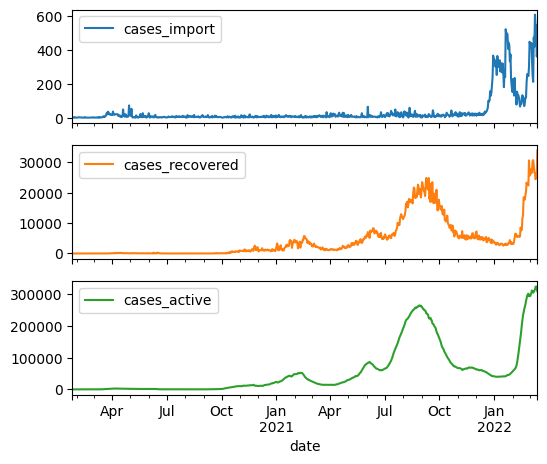

In [5]:
# 3. Basic data inspection

# Define columns involved
plot_cols = ['cases_new', 'cases_import','cases_recovered','cases_active']

# Plot all features
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True,figsize=(6,5))
plt.show()

In [6]:
df[plot_cols].head()

,cases_new,cases_import,cases_recovered,cases_active
0,4,4,0,4
1,0,0,0,4
2,0,0,0,4
3,0,0,0,4
4,3,3,0,7


In [7]:
# Description of data
df[plot_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
cases_import,780.0,36.506410,91.179498,0.0,3.00,7.0,17.0,608.0
cases_recovered,780.0,4490.717949,6476.225456,0.0,64.75,1884.0,5422.5,33872.0
cases_active,780.0,55257.164103,77917.955395,1.0,1418.75,21990.0,66035.0,323618.0


In [8]:
# Check data type
df[plot_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cases_new        779 non-null    object
 1   cases_import     780 non-null    int64 
 2   cases_recovered  780 non-null    int64 
 3   cases_active     780 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 24.5+ KB


In [9]:
# Observations: only 3 plots displayed, no cases_new column. This may due to missing values that results in absence of graph.

In [10]:
# Check for missing values in 'cases_new' column
missing_values = df['cases_new'].isnull().sum()
print(f"Number of missing values in 'cases_new': {missing_values}")

Number of missing values in 'cases_new': 1


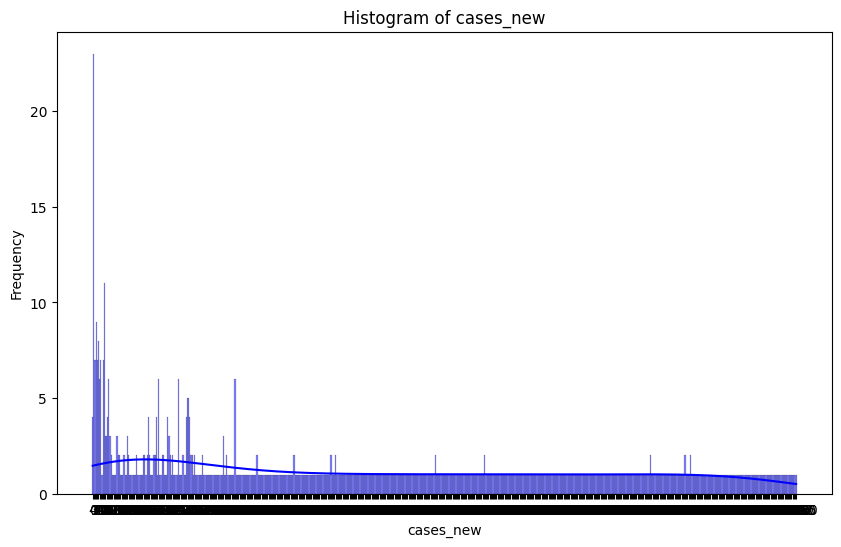

In [11]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['cases_new'], bins=30, kde=True, color='blue')
plt.title('Histogram of cases_new')
plt.xlabel('cases_new')
plt.ylabel('Frequency')
plt.show()

In [12]:
# 4. Data cleaning
df['cases_new'] = pd.to_numeric(df['cases_new'], errors='coerce')
df['cases_new'].fillna(df['cases_new'].median(), inplace=True)

In [13]:
# Check the data type after conversion
print(df['cases_new'].dtype)

float64


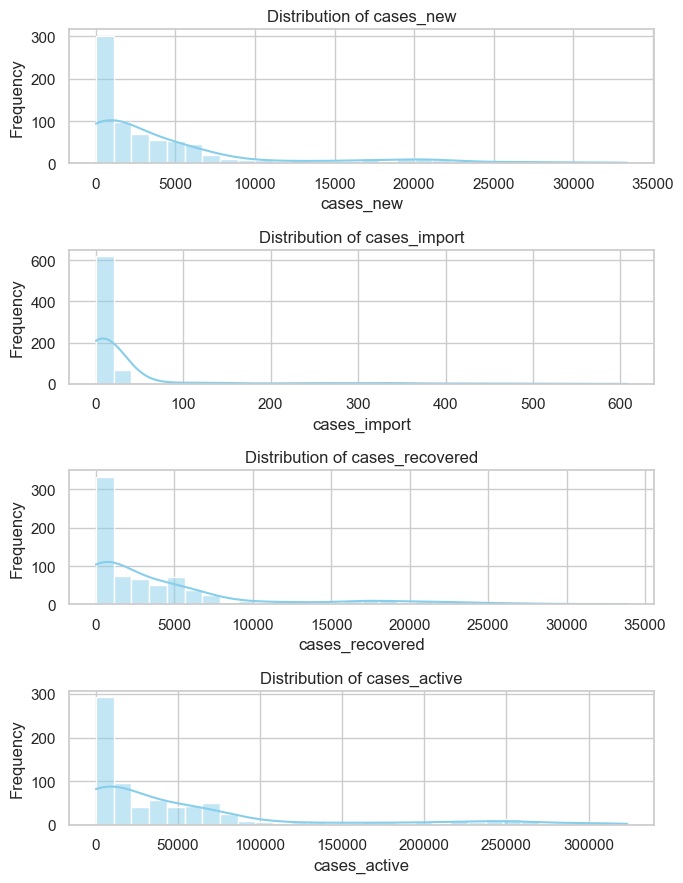

In [14]:
# 5. Data exploration 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Define columns for visualization
columns_to_visualize = ['cases_new', 'cases_import', 'cases_recovered', 'cases_active']

# Create subplots
fig, axes = plt.subplots(nrows=len(columns_to_visualize), ncols=1, figsize=(7,9))

# Plot each column
for i, col in enumerate(columns_to_visualize):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
# Observation : the high frequency of minimum values (0) in the data, it suggests that there are many days with no reported cases for the respective columns (e.g., no new cases, no recovered cases, etc.). This is not uncommon, especially during periods when data might not be reported or recorded.

In [16]:
# 6. Split train validation test

# Create a dictionary mapping column names to their indices
column_indices = {name: i for i, name in enumerate(df.columns)}

# Get the total number of rows in the dataset
n = len(df)

# Select only the specified columns as features
df = df[plot_cols]

# Use 70% of the data for training
train_df = df[0:int(n * 0.7)]

# Use the next 20% of the data for validation
val_df = df[int(n * 0.7):int(n * 0.9)]

# Use the remaining 10% of the data for testing
test_df = df[int(n * 0.9):]

# Get the number of features (columns) in the selected dataset
num_features = df.shape[1]

In [17]:
#7. Data normalization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

C:\Users\USER\AppData\Local\Temp\ipykernel_20740\3170237024.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


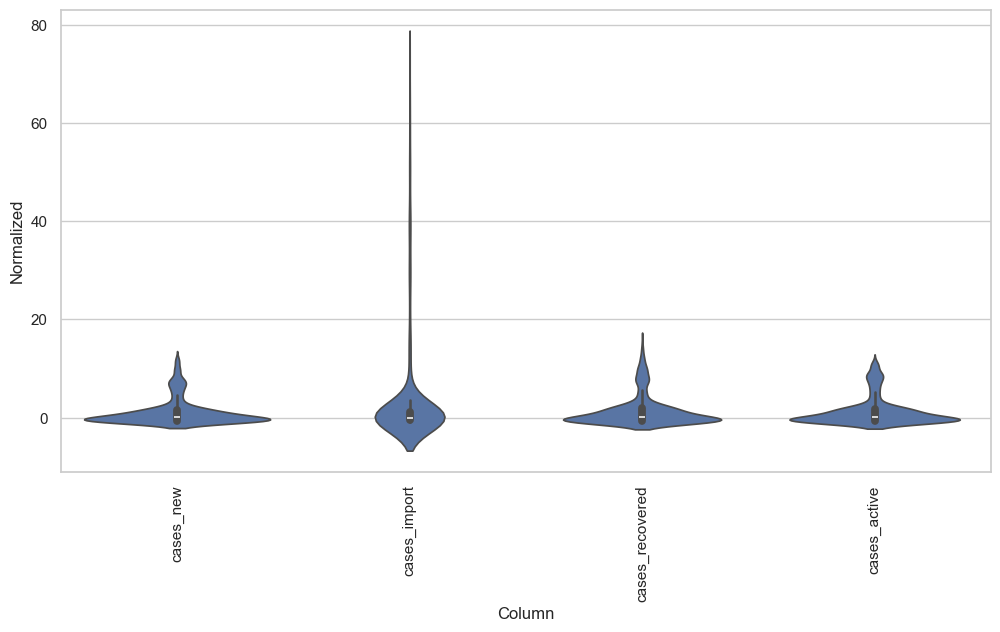

In [18]:
#8. Data inspection after normalization
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


In [19]:
# 9. Data Windowing

# Scenario 1: Single-step

# Model 1: Predict the next day's cases (1-day ahead)
window_single_step_model1 = WindowGenerator(
    input_width=30,
    label_width=30,
    shift=1,
    label_columns=['cases_new'],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df
)


# Scenario 2: Multi-step

# Model 2: Predict cases for the next 30 days (1 to 30 days ahead) using the data from the last 30 days
window_multi_step_model2 = WindowGenerator(
    input_width=30,
    label_width=30,
    shift=30,
    label_columns=['cases_new'],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df
)


In [20]:
# 10. Model development

# Model 1: Predict the next day's cases (1-day ahead)
lstm_model_1 = keras.Sequential([
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1)
])


# Model 2: Predict cases for the next 30 days (1 to 30 days ahead) using the data from the last 30 days
multi_lstm_model_2 = keras.Sequential([
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dropout(0.2),  # Set the dropout rate (e.g., 20%)
    keras.layers.Dense(30),
    keras.layers.Reshape([30, 1])
])

In [42]:
# Create Tensorboard

PATH = os.getcwd()
logpath = os.path.join(PATH, "tensorboard_log", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = TensorBoard(logpath)


In [52]:
# 11. Function to perform model compile and training

MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=15):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience,mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,tensorboard])
  return history

In [53]:
#12.  Compile model and train
# Compile and fit Model 1
history_1 = compile_and_fit(lstm_model_1, window_single_step_model1)

# Compile and fit Model 2
history_2 = compile_and_fit(multi_lstm_model_2, window_multi_step_model2)

Epoch 1/30
17/17 [==============================] - 2s 33ms/step - loss: 0.0184 - mean_absolute_error: 0.0807 - val_loss: 3.4144 - val_mean_absolute_error: 1.4241
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 0.0179 - mean_absolute_error: 0.0803 - val_loss: 3.3975 - val_mean_absolute_error: 1.4201
Epoch 3/30
17/17 [==============================] - 0s 11ms/step - loss: 0.0177 - mean_absolute_error: 0.0792 - val_loss: 3.3880 - val_mean_absolute_error: 1.4181
Epoch 4/30
17/17 [==============================] - 0s 11ms/step - loss: 0.0173 - mean_absolute_error: 0.0784 - val_loss: 3.4804 - val_mean_absolute_error: 1.4499
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 0.0171 - mean_absolute_error: 0.0778 - val_loss: 3.5156 - val_mean_absolute_error: 1.4588
Epoch 6/30
17/17 [==============================] - 0s 11ms/step - loss: 0.0168 - mean_absolute_error: 0.0773 - val_loss: 3.5620 - val_mean_absolute_error: 1.4650
Epoch 7/30
17/17 [====

4/4 [==============================] - 0s 5ms/step - loss: 3.9583 - mean_absolute_error: 1.5430
[3.9582927227020264, 1.5430387258529663]
2/2 [==============================] - 0s 4ms/step - loss: 14.5948 - mean_absolute_error: 2.8626
[14.594771385192871, 2.862583637237549]


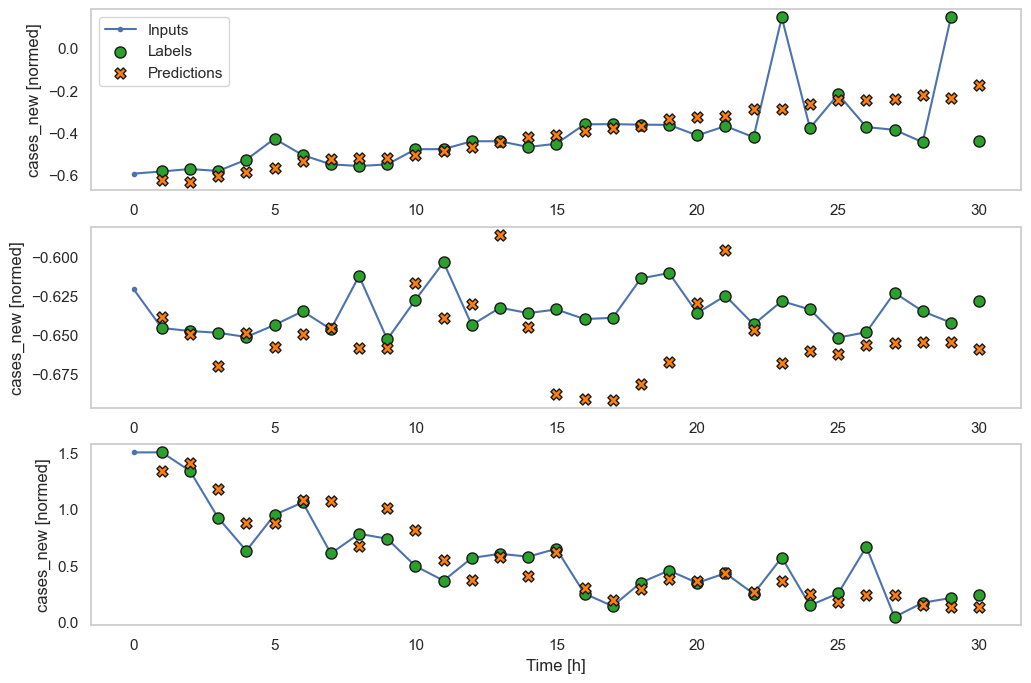

4/4 [==============================] - 0s 3ms/step - loss: 4.9572 - mean_absolute_error: 1.6570
[4.9572296142578125, 1.656965970993042]
1/1 [==============================] - 0s 46ms/step - loss: 75.5500 - mean_absolute_error: 8.1127
[75.55003356933594, 8.112714767456055]


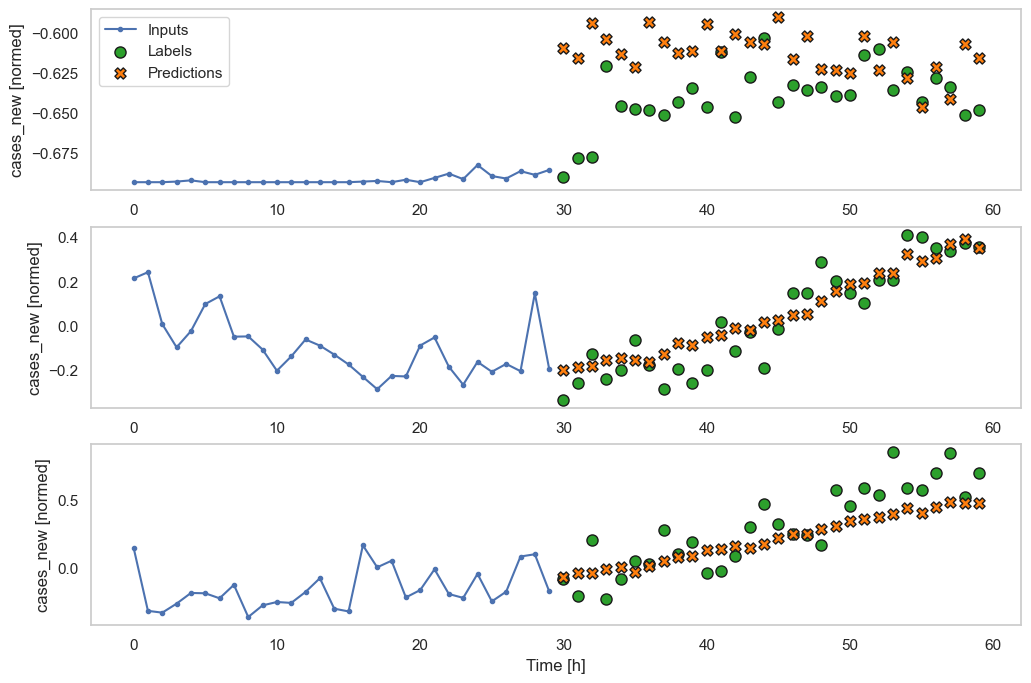

In [54]:
# 13. Evaluate

# Evaluate Model 1
print(lstm_model_1.evaluate(window_single_step_model1.val))
print(lstm_model_1.evaluate(window_single_step_model1.test))

# Plot the result for Model 1
window_single_step_model1.plot(plot_col='cases_new', model=lstm_model_1)
plt.show()


# Evaluate Model 2
print(multi_lstm_model_2.evaluate(window_multi_step_model2.val))
print(multi_lstm_model_2.evaluate(window_multi_step_model2.test))

# Plot the result for Model 2
window_multi_step_model2.plot(plot_col='cases_new', model=multi_lstm_model_2)
plt.show()


In [51]:
# 14. Calculate MAPE

def calculate_and_print_mape(mae, actual_values, model_name):
    sum_absolute_values = np.sum(np.abs(actual_values))
    mape = (mae / sum_absolute_values) * 100
    print(f'MAPE for {model_name} on validation set: {mape:.2f}%')

# Example usage:

# Model 1
mae_model1_val = history_1.history['mean_absolute_error'][-1]
calculate_and_print_mape(mae_model1_val, window_single_step_model1.val_df['cases_new'], model_name="Model 1")

# Model 2
mae_model2_val = history_2.history['mean_absolute_error'][-1]
calculate_and_print_mape(mae_model2_val, window_multi_step_model2.val_df['cases_new'], model_name="Model 2")


MAPE for Model 1 on validation set: 0.01%
MAPE for Model 2 on validation set: 0.03%


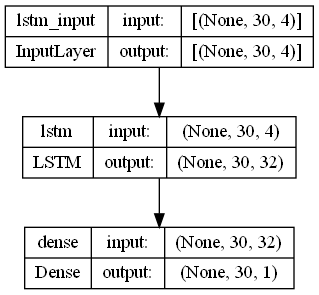

In [50]:
# Architecture of the models Training process plotted using Tensorboard

from tensorflow.keras.utils import plot_model

plot_model(lstm_model_1, to_file='model_1_architecture.png', show_shapes=True)


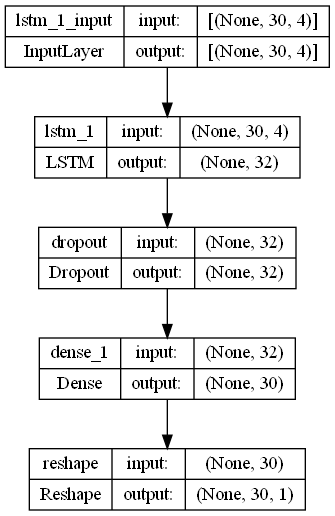

In [28]:

plot_model(multi_lstm_model_2, to_file='model_2_architecture.png', show_shapes=True)